In [23]:
import sys
# sys.path.append('/content/eth-capstone-treewater-deficit/src')
sys.path.append('/home/renku/work/eth-capstone-treewater-deficit/src')
# sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
import os
import glob 
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import collections

from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


from sklearn.preprocessing import StandardScaler
import treewater.utils as utils
# from treewater.utils import *

In [24]:

import importlib
importlib.reload(utils)

# check presence

print(hasattr(utils, "compute_recursive_predictions_fast_torch"))

True


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
# set global random seed
seed = 66666
torch.manual_seed(seed)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # suppress INFO + WARNING

In [31]:
derived_path = "/home/renku/work/eth-capstone-treewater-deficit/data"
data_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/tstoy04"
model_output_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/derived/model_outputs/"

# derived_path = "/content/eth-capstone-treewater-deficit/data"
# data_dir = "/content/eth-capstone-treewater-deficit/data/tstoy04"

# model_output_dir = '/content/eth-capstone-treewater-deficit/data/derived/model_outputs/'

# derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
# data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
# model_output_dir = '/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data/derived/model_outputs/'

In [32]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [33]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [34]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [35]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [36]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [37]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

(array([8368., 2837., 2769., 2630., 2114., 1456.,  740.,  628.,  271.,
         107.]),
 array([0.        , 0.27301828, 0.54603655, 0.81905483, 1.0920731 ,
        1.36509138, 1.63810966, 1.91112793, 2.18414621, 2.45716448,
        2.73018276]),
 <BarContainer object of 10 artists>)

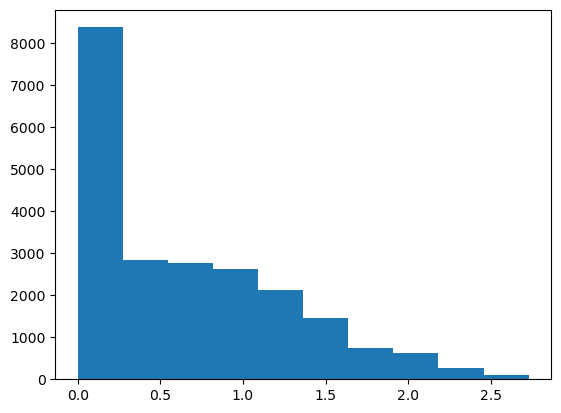

In [38]:
plt.hist(df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [39]:
# Configure features

config = utils.FeatureConfig()
lag_n =7 # use 7 and smaller model size 
label_window_size = 7

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = utils.create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = utils.standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at, train_indexes = utils.get_dataset_NN_torch_with_indices(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at, val_indexes = utils.get_dataset_NN_torch_with_indices(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)





### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [40]:
batch_size = 256
lag_n = lag_n

### Autoregressive

In [41]:
# building datasets
batch_size = batch_size
# train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at

# ensure tensors are on CPU for DataLoader
if train_X_ts_at.device.type == "cuda":
    train_X_ts_at = train_X_ts_at.cpu(); train_day_feat_X_at = train_day_feat_X_at.cpu(); train_static_X_ts_at = train_static_X_ts_at.cpu(); train_y_at = train_y_at.cpu()

# Convert train_indexes to tensor if it's not already
if not isinstance(train_indexes, torch.Tensor):
    train_indexes = torch.tensor(train_indexes)

train_ds = TensorDataset(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, train_y_at, train_indexes)
train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)

# validation dataset

if val_X_ts_at.device.type == "cuda":
    val_X_ts_at = val_X_ts_at.cpu(); val_day_feat_X_at = val_day_feat_X_at.cpu(); val_static_X_ts_at = val_static_X_ts_at.cpu(); val_y_at = val_y_at.cpu()

# Convert val_indexes to tensor if it's not already
if not isinstance(val_indexes, torch.Tensor):
    val_indexes = torch.tensor(val_indexes)

val_loader = DataLoader(TensorDataset(val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at, val_indexes),
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        num_workers=2)


# create cross validate datasets 
# create cross validation dataframes 

train_val_datasets_at = utils.cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df, val_cv_df in train_val_datasets_at:
    X_tr, Xd_tr, Xs_tr, y_tr, train_indexes_cv = utils.get_dataset_NN_torch_with_indices(train_cv_df, feature_window_size=lag_n, 
                                                                                      label_window_size = label_window_size,
                                                                                      autoregressive=True, config=config)
    if X_tr.device.type == "cuda":
        X_tr = X_tr.cpu(); Xd_tr = Xd_tr.cpu(); Xs_tr = Xs_tr.cpu(); y_tr = y_tr.cpu()
    if not isinstance(train_indexes_cv, torch.Tensor):
        train_indexes_cv = torch.tensor(train_indexes_cv)
    tr_loader = DataLoader(TensorDataset(X_tr, Xd_tr, Xs_tr, y_tr, train_indexes_cv),
                           batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available())

    X_va, Xd_va, Xs_va, y_va, val_indexes_cv = utils.get_dataset_NN_torch_with_indices(val_cv_df, feature_window_size=lag_n, 
                                                                                  label_window_size = label_window_size,
                                                                                  autoregressive=True, config=config)
    if X_va.device.type == "cuda":
        X_va = X_va.cpu(); Xd_va = Xd_va.cpu(); Xs_va = Xs_va.cpu(); y_va = y_va.cpu()
    if not isinstance(val_indexes_cv, torch.Tensor):
        val_indexes_cv = torch.tensor(val_indexes_cv)
    va_loader = DataLoader(TensorDataset(X_va, Xd_va, Xs_va, y_va, val_indexes_cv),
                           batch_size=batch_size, shuffle=False, pin_memory=torch.cuda.is_available())

    cv_train_val_ds_at.append((tr_loader, va_loader))

### Build transformer architecture

In [45]:
# defined weighted MAE loss function with weight decay exponentially
def index_weighted_mae_exp_torch(H, decay=0.2):
    weights = torch.exp(-decay * torch.arange(H, dtype=torch.float32))
    weights = weights / weights.sum()

    def loss(y_pred, y_true):
        w = weights.to(y_pred.device, dtype=y_pred.dtype)
        return torch.mean(torch.sum(torch.abs(y_true - y_pred) * w, dim=1))
        #        ↑ sum over horizon, mean over batch
    return loss # do batch mean after summing over horizon

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 64):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class EncoderOnlyForecast(nn.Module):
    """
    Uses TransformerEncoderLayer + TransformerEncoder as the core architecture.
    Inputs:
      past_dynamic: (B, T, n_dyn)
      current_day_exog: (B, n_day)
      static: (B, n_static)
    Output:
      next-day twd: (B,)
    """
    def __init__(
        self,
        n_dyn: int,
        n_day: int,
        n_static: int,
        T: int = 13,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 32,
        dropout: float = 0.1,
        out_nonneg: bool = False,
    ):
        super().__init__()
        self.T = T
        self.out_nonneg = out_nonneg

        # project dynamic features -> d_model
        self.in_proj = nn.Linear(n_dyn, d_model)
        self.pos = PositionalEncoding(d_model, max_len=max(T, 64))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu",
            batch_first=True,  # IMPORTANT: we use (B, T, C)
            norm_first=True,
            # enable_nested_tensor=False
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # combine with day exog + static
        self.day_mlp = nn.Sequential(
            nn.Linear(n_day, 4),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.static_mlp = nn.Sequential(
            nn.Linear(n_static, 4),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.head = nn.Sequential(
            nn.Linear(d_model + 4 + 4, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
        )

    def forward(self, past_dynamic, current_day_exog, static):
        # past_dynamic: (B, T, n_dyn)
        x = self.in_proj(past_dynamic)   # (B, T, d_model)
        x = self.pos(x)
        x = self.encoder(x)              # (B, T, d_model)

        # pool: last token (works well for fixed window)
        x_seq = x[:, -1, :]              # (B, d_model)

        x_day = self.day_mlp(current_day_exog)
        x_stat = self.static_mlp(static)

        z = torch.cat([x_seq, x_day, x_stat], dim=-1)
        y = self.head(z).squeeze(-1)

        if self.out_nonneg:
            y = F.linear(y) # using linear to allow negative outputs for log2 twd

        return y


### set up cross validation

In [ ]:
model_factory = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=32,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# build a training loop

loss_fn = torch.nn.HuberLoss()
optimizer = torch.optim.Adam(model_factory().parameters(), lr=1e-3/2)

rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = utils.cross_validate_transformer(
    model_factory=model_factory,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    config = config,
    lag_n = lag_n,
    batch_size = batch_size,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)


model_factory_2 = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=64,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)


rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2 = utils.cross_validate_transformer(
    model_factory=model_factory_2,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    config = config,
    lag_n = lag_n,
    batch_size = batch_size,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 7))

ax1.bar(np.arange(0.75,4.75, 1), rmses_cv_at, color='tab:orange', width = 0.4)
ax1.bar(np.arange(1.25,5.25,1),rmses_cv_at2, color = "tab:blue", width = 0.4)

ax1.set_xticks(range(1,5))
ax1.legend(['model size =32', 'hidden size =64'])
ax1.set_ylabel('RMSE - AR')
ax1.set_xlabel("CV fold")
ax1.set_title("RMSE - AR")
# rmses_cv_at


ax2.bar(np.arange(0.75, 4.75, 1), r2s_cv_at, color='tab:orange', width = 0.4)
ax2.bar(np.arange(1.25,5.25,1),r2s_cv_at2, color = "tab:blue", width = 0.4)
ax2.set_xticks(range(1,5))
ax2.legend(['hidden size =32', 'hidden size =64'])
ax2.set_ylabel('R2 - AR')
ax2.set_xlabel("CV fold")
ax2.set_title("R2 - AR")   


ax3.bar([1,2],  [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax3.errorbar(x = [1,2], y = [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)], 
             yerr=[np.std(rmses_cv_at), np.std(rmses_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax3.set_xticks([1,2])
ax3.set_xticklabels(['hidden size =32', 'hidden size =64'])


ax4.bar([1,2],  [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax4.errorbar(x = [1,2], y = [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)], 
             yerr=[np.std(r2s_cv_at), np.std(r2s_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax4.set_xticks([1,2])
ax4.set_xticklabels(['hidden size =32', 'hidden size =64'])

In [ ]:
# visualize CV results
for fold in range(len(rmses_cv_at)):
    print(f'Fold {fold + 1}: Recursive RMSE={rmses_cv_at[fold]:.4f}, 1-day RMSE={rmses_cv_1d_at[fold]:.4f}, Recursive R2={r2s_cv_at[fold]:.4f}, 1-day R2={r2s_cv_1d_at[fold]:.4f}')

In [ ]:
preds, trues = utils.compute_recursive_predictions_fast_torch_training(model_ar,
                                            train_df_at_batch.iloc[1:128, ],
                                               feature_window_size = lag_n,
                                               label_window_size = label_window_size,
                                               shift = 1,
                                               config = config,
                                               batch_size = 128,
                                               rolling = True)

# preds.to(device)
print(preds.shape)
print(trues.shape)




maybe test different model size?

In [46]:
def train_one_epoch_rolling_loss(model, epoch_index, train_loader, train_df_at, loss_fn, optimizer, 
                                config,
                                 device=None, log_every=100,
                                 ):
    device = device or next(model.parameters()).device
    running_loss = 0.0
    sse = 0.0
    n_samples = 0
    n_batches = 0

    model.train()
    for i, batch in enumerate(train_loader):
        X_dyn, X_day, X_static, labels, indexes = batch
        indexes = indexes.numpy()
        # X_dyn = X_dyn.to(device); X_day = X_day.to(device); X_static = X_static.to(device); 
        labels = labels.to(device)

        train_df_at_batch = train_df_at.iloc[indexes[0,0]:indexes[-1, -1]+1, ]
        optimizer.zero_grad()
        
        outputs_horizon, targets_horizon = utils.compute_recursive_predictions_fast_torch_training(
            model,
            train_df_at_batch,
            feature_window_size=X_dyn.shape[1],
            label_window_size=labels.shape[1],
            shift=1,
            batch_size = 256,
            config=config,
            rolling = True
        )
        
        # Skip if no valid windows were created
        if outputs_horizon.shape[0] == 0:
            continue
            
        # Skip if no valid windows were created
        if outputs_horizon.shape[0] == 0:
            continue
        
        # Ensure tensors are on the correct device and maintain gradients
        # DO NOT use torch.tensor() as it breaks the computation graph
        if not isinstance(outputs_horizon, torch.Tensor):
            outputs_horizon = torch.as_tensor(outputs_horizon, dtype=torch.float32, device=device)
        else:
            outputs_horizon = outputs_horizon.to(device)
            
        if not isinstance(targets_horizon, torch.Tensor):
            targets_horizon = torch.as_tensor(targets_horizon, dtype=torch.float32, device=device)
        else:
            targets_horizon = targets_horizon.to(device)
        
        # Ensure tensors are 2D for loss function
        if outputs_horizon.dim() == 1:
            outputs_horizon = outputs_horizon.unsqueeze(0)
        if targets_horizon.dim() == 1:
            targets_horizon = targets_horizon.unsqueeze(0)
            
            
        loss = loss_fn(outputs_horizon, targets_horizon)
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item())
        batch_sse = float(F.mse_loss(outputs_horizon, targets_horizon, reduction='sum').item())
        sse += batch_sse
        n_samples += targets_horizon.numel()
        n_batches += 1

        if (i + 1) % log_every == 0:
            print(f'  batch {i+1} loss: {running_loss / n_batches:.4f}')

    avg_batch_loss = running_loss / n_batches if n_batches > 0 else float("nan")
    train_rmse = math.sqrt(sse / n_samples) if n_samples > 0 else float("nan")
    return avg_batch_loss, train_rmse


In [ ]:
# train baseline model on full training set with rolling loss
model_ar = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=64, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=32, # dimension of feedforward network,
    dropout=0.1,
    out_nonneg=False
).to(device)

optimizer = torch.optim.Adam(model_ar.parameters(), lr=1e-3/2)
loss_fn = index_weighted_mae_exp_torch(label_window_size, decay=0.2)


# writer = SummaryWriter(os.path.join(model_output_dir, f'transformer_ar{timestamp}'))
epoch_number = 0

history = {"train_loss": [], "train_rmse": [], "val_loss": [], "val_rmse": [],
           "p_tf": []}
best_vloss = float("inf")

EPOCHS = 100

best_vloss = 1_000_000.


for epoch in range(EPOCHS):
    
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_ar.train(True)
    avg_loss, train_rmse = train_one_epoch_rolling_loss(model_ar, epoch_number, train_loader, train_df_at, loss_fn, optimizer,
                                                        config,
                                           device=device, log_every=100)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model_ar.eval()
    val_sse = 0.0
    val_n = 0   
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (X_dyn_val, X_day_val, X_static_val, vlabels, v_indexes) in enumerate(val_loader):
            v_indexes = v_indexes.numpy()
            voutputs_horizon, vtargets_horizon = utils.compute_recursive_predictions_fast_torch_training(
                model_ar,
                val_df_at.iloc[v_indexes[0,0]:v_indexes[-1, -1]+1, ],
                feature_window_size=X_dyn_val.shape[1],
                label_window_size=vlabels.shape[1],
                shift=1,
                batch_size = 256,
                config=config,
                rolling = True
            )
            voutputs_horizon = torch.as_tensor(voutputs_horizon).to(device)
            vtargets_horizon = torch.as_tensor(vtargets_horizon).to(device)
            vloss = loss_fn(voutputs_horizon, vtargets_horizon.to(device))
            running_vloss += vloss
            val_sse += F.mse_loss(voutputs_horizon, vtargets_horizon.to(device), reduction='sum').item()
            val_n += vtargets_horizon.numel()


    avg_vloss = running_vloss / (i + 1)
    avg_vloss_f = avg_vloss.item() if hasattr(avg_vloss, "item") else float(avg_vloss)

    val_rmse = math.sqrt(val_sse / val_n) if val_n > 0 else float("nan")
    print(f'Train loss:{avg_loss:.4f}, Train RMSE:{train_rmse:.4f}, Val loss:{avg_vloss:.4f}, Val RMSE:{val_rmse:.4f}')
    # Log the running loss averaged per batch
    # for both training and validation

    history["train_loss"].append(float(avg_loss))
    history["val_loss"].append(avg_vloss_f)
    history["train_rmse"].append(train_rmse)
    history["val_rmse"].append(val_rmse)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(model_output_dir, f'model_rolling_loss{epoch_number}')
        torch.save(model_ar.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.4092, Train RMSE:0.5298, Val loss:0.2618, Val RMSE:0.3606
EPOCH 2:
Train loss:0.2587, Train RMSE:0.3639, Val loss:0.2092, Val RMSE:0.3045
EPOCH 3:
Train loss:0.2313, Train RMSE:0.3343, Val loss:0.1800, Val RMSE:0.2851
EPOCH 4:
Train loss:0.2227, Train RMSE:0.3374, Val loss:0.1766, Val RMSE:0.2897
EPOCH 5:
Train loss:0.2172, Train RMSE:0.3225, Val loss:0.1746, Val RMSE:0.2857
EPOCH 6:
Train loss:0.2146, Train RMSE:0.3152, Val loss:0.1675, Val RMSE:0.2766
EPOCH 7:
Train loss:0.2072, Train RMSE:0.3096, Val loss:0.1749, Val RMSE:0.2817
EPOCH 8:
Train loss:0.2025, Train RMSE:0.3051, Val loss:0.1622, Val RMSE:0.2744
EPOCH 9:


In [ ]:
# predction on validation set
model_ar.eval()
model_best = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=64, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=32, # dimension of feedforward network,
    dropout=0.1,
    out_nonneg=False
).to(device) # initiate a new model
model_best.load_state_dict(torch.load(model_path))
preds = []
actuals = []
with torch.no_grad():
    for i, (X_dyn_val, X_day_val, X_static_val, vlabels) in enumerate(val_loader):
        voutputs = model_best(X_dyn_val.to(device), X_day_val.to(device), X_static_val.to(device))
        preds.append(voutputs.cpu().numpy().flatten())
        actuals.append(vlabels.cpu().numpy().flatten())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

In [ ]:
plt.plot(range(0, EPOCHS), history["train_loss"], label="Train Loss")
plt.plot(range(0, EPOCHS), history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()

In [ ]:
# next day prediction performance
rmse = root_mean_squared_error(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds))
r2 = r2_score(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds))

plt.scatter(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds), alpha=0.3)
plt.text(x=4, y = 4, s = f"RMSE:{rmse_at:.3f}")
plt.text(x= 4, y = 4.2, s=f"R2:{r2_at:.3f}")



In [ ]:
y_pred_val_at, y_val_at = utils.compute_recursive_predictions_fast_torch(model_best.to(device), val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=128)

In [ ]:
rmse_at= root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at))
r2_at = r2_score(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at))
print(f"Recursive prediction on validation set - RMSE: {rmse_recursive:.4f}, R2: {r2_recursive:.4f}")

- performance appears more stable when model size is 64

In [ ]:
model_size = 64

## Fine-tune model

In [ ]:
# build a fresh model with identical architecture
model_FT = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_FT.load_state_dict(model_ar.state_dict())
# fine tune the model within CV

rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = utils.cross_validation_torch_FT(
    model_FT,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    batch_size = batch_size,
    loss_fn = loss_fn,
    optimizer_class = torch.optim.Adam,
    lr = 0.0005,
    n_epochs=50,
    device = device,
    if_log = True
    
)



In [ ]:
# visualize CV results
for fold in range(len(rmses_cv_at_finetune)):
    print(f'Fold {fold + 1}: Recursive RMSE={rmses_cv_at_finetune[fold]:.4f}, 1-day RMSE={rmses_cv_1d_at_finetune[fold]:.4f}, Recursive R2={r2s_cv_at_finetune[fold]:.4f}, 1-day R2={r2s_cv_1d_at_finetune[fold]:.4f}')

In [ ]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = utils.build_autoregressive_training_data_fast_torch(
    model=model_FT,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
    device = device
)

train_ds_ar = TensorDataset(X_dyn_ar.cpu(), X_day_ar.cpu(), X_static_ar.cpu() , y_ar.cpu())
train_loader_ar = DataLoader(train_ds_ar,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)



In [ ]:
# train final model on the full training set with AR-corrupted data
E2 = 60


# build a fresh model with identical architecture
model_FT_all = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_FT_all.load_state_dict(model_ar.state_dict())
# fine tune the model within CV

# now fine-tune on AR-corrupted dataset
optimizer = torch.optim.Adam(model_FT_all.parameters(), lr=1e-3/2)
model_FT_all, history_FT_all = utils.train_transformer(
    model_FT_all, train_loader_ar, val_loader, loss_fn, optimizer, n_epochs=E2, device=device
    
)

In [ ]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = utils.compute_recursive_predictions_fast_torch(model_FT_all, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [ ]:
r2_FT = r2_score(utils.clip_and_inverse_log2_transform(y_val_at_FT), utils.clip_and_inverse_log2_transform(y_pred_val_at_FT))
rmse_FT = root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at_FT), utils.clip_and_inverse_log2_transform(y_pred_val_at_FT))

print(f"r2: {r2_FT}\n rmse: {rmse_FT}")

### scheduled sampling - train model

cross validation - implement cross validation

In [ ]:
# build a fresh model with identical architecture
n_epochs = 50
model_at_ar_cv = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.load_state_dict(model_ar.state_dict())

rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = utils.cross_validation_torch_scheduled(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    n_epochs=n_epochs,
    batch_size = batch_size,
    loss_fn = loss_fn,
    optimizer_class = torch.optim.Adam,
    lr = 0.0005,
    p_min = 0.1,
    warmup_epochs=3,
    frac_decay=0.9,
    slow_decay=True,
    device = device,
    if_log = True)




In [ ]:
# now do scheduled sampling training on the full training set
num_epochs = 120


# init model with same architecture
model_ss = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)
# copy weights from model_at (teacher-forced trained model)
model_ss.load_state_dict(model_ar.state_dict())

optimizer = torch.optim.Adam(model_ss.parameters(), lr=1e-3/2)

model_ss_best, history_at_ar = utils.train_transformer_scheduled(model_ss, train_df_at, val_loader, lag_n, 
                                                          config, batch_size, 
                                                            loss_fn, optimizer, n_epochs=num_epochs,
                                                            p_min = 0.1, warmup_epochs=3, frac_decay = 0.9, 
                                                            epoch_per_step = 15,
                                                            slow_decay = True,
                                                            device=device)

maybe adjust loss function?

In [ ]:
# save training history
train_his_path = os.path.join(derived_path,"derived", "training_history", "history_tranformer_scheduled_sampling_log.npy")
np.save(train_his_path, history_ar_at)

# save best model
model_path_best = os.path.join(model_output_dir, f'model_transformer_scheduled.pth')
torch.save(model_ss_best.state_dict(), model_path_best)



In [ ]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= utils.compute_recursive_predictions_fast_torch(model_ss_best, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(utils.clip_and_inverse_log2_transform(y_val_at_ar),utils.clip_and_inverse_log2_transform(y_pred_val_at_ar))
rmse_at_ar = root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at_ar), utils.clip_and_inverse_log2_transform(y_pred_val_at_ar))

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

In [ ]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (model size = 32)'] *4 + ['teacher_forcing (model size = 64)'] *4 + ['fine_tuned (model size = 64)'] *4 + ['scheduled_sampling (model size = 64)'] *4,    
    "cv_fold"  : [i for i in range(1, len(rmses_cv_at_ar) + 1)] *4,
    # "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

In [ ]:
sns.set(style="white", font_scale=1,
        rc={"figure.figsize": (6, 4)})

metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


In [ ]:
# Create figure with 3 subplots showing model final performance

def ensure_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.numpy()
    return np.asarray(x)

model_type = "Transformer"
y_val_at = utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at).reshape(-1))
y_pred_val_at = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at).reshape(-1))
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 5))


# First subplot - Autoregressive Model Predictions hidden 32
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [y_val_at.min(), y_val_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"{model_type} Teacher forcing autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax1.text(y_val_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# plot fine-tuned 
ax2.scatter(x =  utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)), y = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)), color="grey", alpha=0.5)
ax2.set_xlabel("True TWD")
ax2.set_ylabel("Predicted TWD")
x_range = [utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).min(), utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()]
ax2.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax2.plot(x_range, [i+rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.plot(x_range, [i-rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.set_title(f"{model_type} Fine-tuned autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax2.text(utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()-1.5,utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_FT:.3f}\n$R^2:$ {r2_FT:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))   


# plot scheduled sampling 
ax3.scatter(x = utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)), y = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)), color="grey", alpha=0.5)
ax3.set_xlabel("True TWD")
ax3.set_ylabel("Predicted TWD")
x_range = [utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).min(), utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()]
ax3.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax3.plot(x_range, [i+rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.plot(x_range, [i-rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.set_title(f"{model_type} autoregressive Model with Scheduled Sampling\nwith {lag_n} lags (N=16 hidden units)")
ax3.text(utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()-1.5,utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_at_ar:.3f}\n$R^2:$ {r2_at_ar:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  

plt.tight_layout()
plt.show()



- timeseries prediction across timestep 

trained with logged values

why the performance is so bad ..
- try the same on ridge regression?
- pick the best model in different training strategy?